# **Emotion Intensity (EmoInt) on Tweets**
# by Shyam Prakash J<br> 


In [72]:
#for data processing
import pandas as pd
import numpy as np
import string
import re

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#for nlp
from collections import Counter
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#for regression model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
from sklearn import metrics
from sklearn.metrics import r2_score

#for evaluation
import scipy

# EDA
<a id='EDA'></a>

In [73]:
#load train data
#cols = ['id', 'text', 'label', 'intensity']
anger_train = pd.read_csv('/content/anger-ratings-0to1.train.txt',sep='\t',index_col=0)
fear_train = pd.read_csv('/content/fear-ratings-0to1.train.txt',sep='\t',index_col=0)
sad_train = pd.read_csv('/content/sadness-ratings-0to1.train.txt',sep='\t',index_col=0)
joy_train = pd.read_csv('/content/joy-ratings-0to1.train.txt',sep='\t',index_col=0)

joy_train.head()

,tweet,tweettype,score
id,,,
30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980
30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958
30002,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,0.940
30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938
30004,I feel so blessed to work with the family that...,joy,0.938


In [74]:
joy_train.columns

Index(['tweet', 'tweettype', 'score'], dtype='object')

In [75]:
#see ratio of total instance of each emotion
frames = [anger_train, fear_train, sad_train, joy_train]
data_training_ = pd.concat(frames)
data_training_.reset_index(inplace=True)
data_training_.tweettype.value_counts()

fear       1147
anger       857
joy         823
sadness     786
Name: tweettype, dtype: int64

In [76]:
data_training=pd.DataFrame(data_training_)

In [77]:
data_training.head()

,id,tweet,tweettype,score
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [78]:
#adding word_count, char_count, and punc_count feature
punc = string.punctuation
data_training['word_count'] = data_training['tweet'].apply(lambda x:len(x.split()))
data_training['char_count'] = data_training['tweet'].apply(lambda x:len(x.replace(' ','')))
data_training['punc_count'] = data_training['tweet'].apply(lambda x:len([a for a in x if a in punc]))
data_training.head()

,id,tweet,tweettype,score,word_count,char_count,punc_count
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,18,79,12
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,23,97,4
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,19,90,4
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,24,111,13
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,24,102,6


In [79]:
data_training.isnull().sum()

id            0
tweet         0
tweettype     0
score         0
word_count    0
char_count    0
punc_count    0
dtype: int64

Text(0.5, 1.0, 'Average Intensity for Each Label')

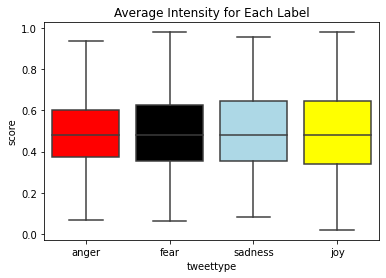

In [80]:
#see average intensity of each emotion
colors = ['red', 'black', 'lightblue', 'yellow']
bplot = sns.boxplot(data=data_training, x='tweettype', y='score')
for i in range(4):
    bplot.artists[i].set_facecolor(colors[i])
plt.title('Average Intensity for Each Label')

Text(0.5, 1.08, 'Relationship between char_count and intensity')

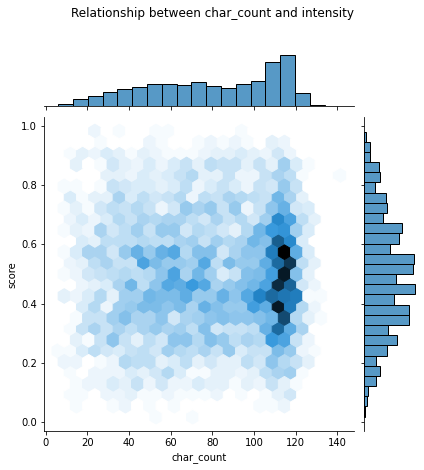

In [81]:
#See the relationship between intensity and character, word, and, punctuation counts
sns.jointplot(data=data_training, x='char_count', y='score', kind='hex')
plt.suptitle('Relationship between char_count and intensity', y=1.08)

Text(0.5, 1.08, 'Relationship between word_count and intensity')

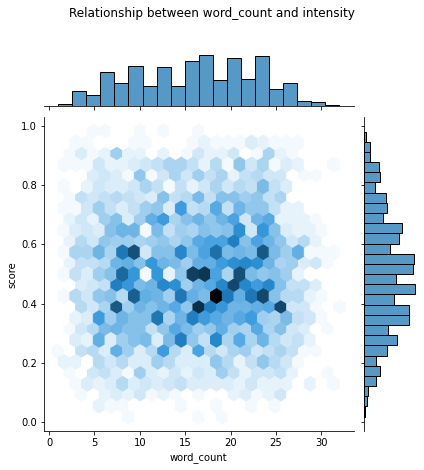

In [82]:
sns.jointplot(data=data_training, x='word_count', y='score', kind='hex')
plt.suptitle('Relationship between word_count and intensity', y=1.08)

Text(0.5, 1.08, 'Relationship between punct_count and intensity')

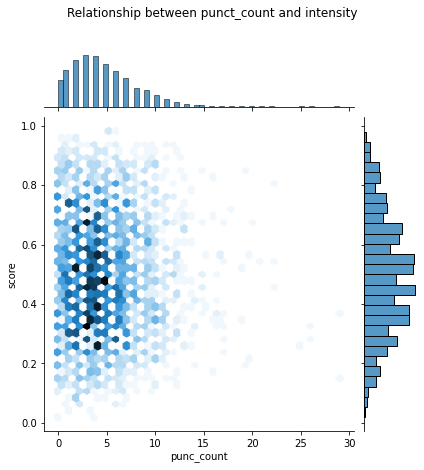

In [83]:
sns.jointplot(data=data_training, x='punc_count', y='score', kind='hex')
plt.suptitle('Relationship between punct_count and intensity', y=1.08)

In [84]:
#Join text in each emotion
join_text_fear = ' '.join(data_training[data_training['tweettype']=='fear']['tweet'].values)
join_text_anger = ' '.join(data_training[data_training['tweettype']=='anger']['tweet'].values)
join_text_joy = ' '.join(data_training[data_training['tweettype']=='joy']['tweet'].values)
join_text_sadness = ' '.join(data_training[data_training['tweettype']=='sadness']['tweet'].values)

In [85]:
join_text_fear

"I feel like I am drowning. #depression #anxiety #falure #worthless I get so nervous even thinking about talking to ****** I wanna die I lost my blinders .... #panic I feel like I am drowning. #depression  #falure #worthless This is the scariest American Horror Story out of all of them... I'm gonna have to watch in the daytime. #frightened @mgcsartwork I nearly started crying and having a full on panic attack after tatinof bc of the crowds so I feel him I have to finally tell my therapist about my sexuality ... last frontier ... not sure I can do it in the AM #fear #SingleGirlProblems @laura221b I don't think I've ever moved so fast in a panic in all my life 😂 Gave me such a fright 😓 My bus was in a car crash... I'm still shaking a bit... This week was an absolute horror and this was the icing on the cake... #terrible My bus was in a car crash... I'm still shaking a bit... This week was an absolute horror and this was the icing on the cake...  procrasting is fun until im an hour away f

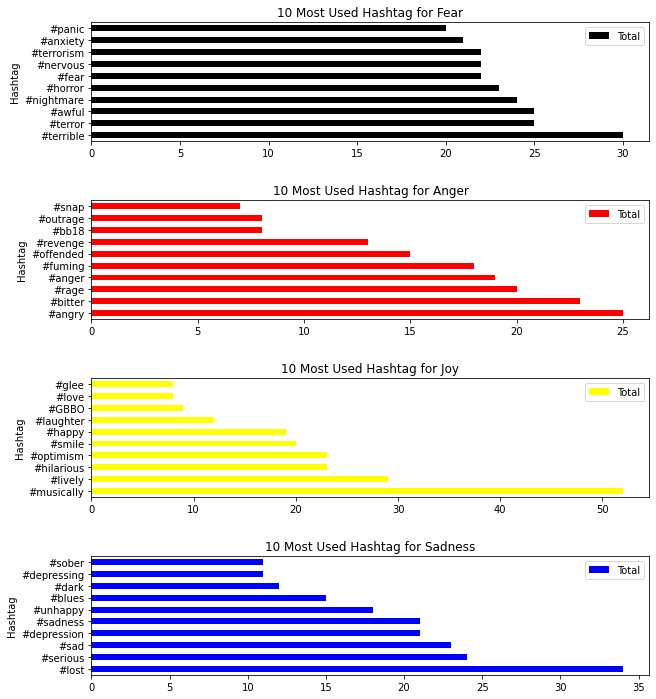

In [86]:
#Show 10 most used hashtag for each emotion
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
fig.subplots_adjust(hspace=.5)

fear_counter = Counter(word for word in join_text_fear.split(' ') if word != '' and word[0]=='#')
most_common = fear_counter.most_common(10)
df = pd.DataFrame(most_common, columns=["Hashtag", "Total"])
df.plot.barh(y="Total", x="Hashtag", ax=ax1, color="black",title="10 Most Used Hashtag for Fear")

anger_counter = Counter(word for word in join_text_anger.split(' ') if word != '' and word[0]=='#')
most_common = anger_counter.most_common(10)
df = pd.DataFrame(most_common, columns=["Hashtag", "Total"])
df.plot.barh(y="Total", x="Hashtag", ax=ax2, color="red",title="10 Most Used Hashtag for Anger")

joy_counter = Counter(word for word in join_text_joy.split(' ') if word != '' and word[0]=='#')
most_common = joy_counter.most_common(10)
df = pd.DataFrame(most_common, columns=["Hashtag", "Total"])
df.plot.barh(y="Total", x="Hashtag", ax=ax3, color="yellow",title="10 Most Used Hashtag for Joy")

sadness_counter = Counter(word for word in join_text_sadness.split(' ') if word != '' and word[0]=='#')
most_common = sadness_counter.most_common(10)
df = pd.DataFrame(most_common, columns=["Hashtag", "Total"])
df.plot.barh(y="Total", x="Hashtag", ax=ax4, color="blue",title="10 Most Used Hashtag for Sadness")

# Training
<a id='Training'></a>

In [87]:
#Cleaning text by removing links, numbers, @, stopwords, and transform all to lower case
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[A-Za-z0-9./]+'
pat3 = r'[0-9]+'
combined_pat = r'|'.join((pat1, pat2, pat3))
stop_words= set(stopwords.words('english'))

def tweet_cleaner(data_frame):
    print('Cleaning and parsing the tweets.....\n')
    clean_data = []
    for index, row in data_frame.iterrows():
        stripped = re.sub(combined_pat, '', row.tweet)
        lower_case = stripped.lower()
        words = tok.tokenize(lower_case)
        filtered_words = [w for w in words if not w in stop_words]
        clean_data.append((' '.join(filtered_words)).strip())
        
    print('Done!')
    return clean_data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
clean_data_training_list = tweet_cleaner(data_training)

Cleaning and parsing the tweets.....

Done!


In [89]:
clean_data_training_list

['fu * k ! heck ! moved fridge !... knock landlord door . # angry # mad ##',
 "indian uber driver called someone n word . ' moving vehicle ' jumped # disgusted",
 'asked parcel delivered pick store address # fuming # poorcustomerservice',
 'ef whichever butt wipe pulled fire alarm davis bc sound asleep # pissed # angry # upset # tired # sad # tired # hangry ######',
 "' join put phone , talk rude . taking money acc willynilly ! # fuming",
 'blood boiling',
 "' still got whole season wentworth watch stupid cunt work ruins us 😭😭 # raging # oldcunt",
 "tracking show equipment delivered , ' ? service suddenly delayed ? ' already weeks . # fuming",
 'legit furious , people fucking idiots .',
 'suppose work ? wtf dude ? thanks pissing .',
 'im mad power rangers . im incensed . im furious .',
 'wont use using !! guys cant get nothing right !! # fuming',
 'bitches aggravate like inspires biggest cunt known man kind ?',
 'come glasgow night working . fucking gutted , waiting appearance ages # r

In [90]:
#making one-hot encoding of label
labels = pd.get_dummies(data_training['tweettype'])
intensity=data_training['score']
#applying bag of words and tf-idf technique to vectorise the tweets
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 3))
X_BoW = vectorizer.fit_transform(data_training.tweet)
X_BoW = pd.DataFrame.sparse.from_spmatrix(X_BoW).join(labels)
X_BoW['score'] = intensity

vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer_tfidf.fit_transform(data_training.tweet)
X_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf).join(labels)
X_tfidf['score'] = intensity


In [91]:
print(X_BoW)

      0  1  2  3  4  5  6  7  ...  997  998  999  anger  fear  joy  sadness  score
0     0  0  0  0  0  0  0  0  ...    0    0    0      1     0    0        0  0.938
1     0  0  0  0  0  0  0  0  ...    0    0    0      1     0    0        0  0.896
2     0  0  0  0  0  0  0  0  ...    0    0    0      1     0    0        0  0.896
3     0  0  0  0  0  0  0  0  ...    0    0    0      1     0    0        0  0.896
4     0  0  0  0  0  0  0  0  ...    0    0    0      1     0    0        0  0.896
...  .. .. .. .. .. .. .. ..  ...  ...  ...  ...    ...   ...  ...      ...    ...
3608  0  0  0  0  0  0  0  0  ...    0    0    0      0     0    1        0  0.058
3609  0  0  0  0  0  0  0  0  ...    0    0    0      0     0    1        0  0.040
3610  0  0  0  0  0  0  0  0  ...    0    0    0      0     0    1        0  0.040
3611  0  0  0  0  0  0  0  0  ...    0    0    0      0     0    1        0  0.020
3612  0  0  0  0  0  0  0  0  ...    0    0    0      0     0    1        0  0.019

[36

In [92]:
X_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,anger,fear,joy,sadness,score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,0,0,0,0.938
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.351266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,0,0,0,0.896
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,0,0,0,0.896
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,0,0,0,0.896
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277475,0.0,0.0,0.0,0.0,1,0,0,0,0.896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,1,0,0.058
3609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,1,0,0.040
3610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,1,0,0.040
3611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,1,0,0.020


In [93]:
x = X_BoW.drop(['score'], axis=1)
y = X_BoW.score


In [94]:
x1 = X_tfidf.drop(['score'], axis=1)
y1 = X_tfidf.score

## **Pure Statiscal Models**

Ordinary Least Square

In [95]:
import statsmodels.formula.api as smf

In [96]:
bow_ols= smf.ols(formula="score ~ anger + fear + joy + sadness",data=X_BoW)
result_bow_ols = bow_ols.fit()


In [97]:
tf_ols= smf.ols(formula="score ~ anger + fear + joy + sadness",data=X_tfidf)
result_tf_ols = tf_ols.fit()


Generalised Linear Model

In [98]:
bow_glm=smf.glm (formula="score ~ anger + fear + joy + sadness",data=X_BoW)
result_bow_glm = bow_glm.fit()

In [99]:
tf_glm=smf.glm (formula="score ~ anger + fear + joy + sadness",data=X_tfidf)
result_tf_glm = tf_glm.fit()

Robust Linear Models

In [100]:
bow_rlm=smf.rlm (formula="score ~ anger + fear + joy + sadness",data=X_BoW)
result_bow_rlm = bow_rlm.fit()

In [101]:
tf_rlm=smf.rlm (formula="score ~ anger + fear + joy + sadness",data=X_tfidf)
result_tf_rlm = bow_rlm.fit()

# **DEEP LEARNING MODEL**

Artificial Neural Network

In [102]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

In [103]:
model=Sequential()
model.add(Dense(400,activation='relu',input_dim=1004))
model.add(Dense(240,activation='relu'))
model.add(Dense(240,activation='relu'))
model.add(Dense(240,activation='relu'))
model.add(Dense(240,activation='relu'))
model.add(Dense(1))

In [104]:
model.compile(optimizer='Adam',loss='mean_absolute_error',metrics=['accuracy'])

In [105]:
model.fit(x, y, epochs=50)

Epoch 1/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1616 - accuracy: 0.0000e+00
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1145 - accuracy: 0.0000e+00
Epoch 3/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0955 - accuracy: 0.0000e+00
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0850 - accuracy: 0.0000e+00
Epoch 5/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0762 - accuracy: 0.0000e+00
Epoch 6/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 7/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0592 - accuracy: 0.0000e+00
Epoch 8/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0538 - accuracy: 0.0000e+00
Epoch 9/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0511 - accuracy: 0.0000e+00
Epoch 10/50
113/113 [==============================] - 1s 8ms/st

In [106]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 400)               402000    
                                                                 
 dense_13 (Dense)            (None, 240)               96240     
                                                                 
 dense_14 (Dense)            (None, 240)               57840     
                                                                 
 dense_15 (Dense)            (None, 240)               57840     
                                                                 
 dense_16 (Dense)            (None, 240)               57840     
                                                                 
 dense_17 (Dense)            (None, 1)                 241       
                                                                 
Total params: 672,001
Trainable params: 672,001
Non-tr

In [107]:
model1=Sequential()
model1.add(Dense(400,activation='relu',input_dim=1004))
model1.add(Dense(240,activation='relu'))
model1.add(Dense(240,activation='relu'))
model1.add(Dense(240,activation='relu'))
model1.add(Dense(240,activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer='Adam',loss='mean_absolute_error',metrics=['accuracy'])

In [108]:
model1.fit(x1, y1, epochs=50)

Epoch 1/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1555 - accuracy: 0.0000e+00
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1110 - accuracy: 0.0000e+00
Epoch 3/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0925 - accuracy: 0.0000e+00
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0780 - accuracy: 0.0000e+00
Epoch 5/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 6/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0659 - accuracy: 0.0000e+00
Epoch 7/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0590 - accuracy: 0.0000e+00
Epoch 8/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0534 - accuracy: 0.0000e+00
Epoch 9/50
113/113 [==============================] - 1s 8ms/step - loss: 0.0493 - accuracy: 0.0000e+00
Epoch 10/50
113/113 [==============================] - 1s 8ms/st

In [109]:
#Load data development to test the models
#cols = ['id', 'text', 'label', 'intensity']


anger_dev = pd.read_csv('/content/anger-ratings-0to1.dev.gold.txt',sep='\t', index_col=0)
fear_dev = pd.read_csv('/content/fear-ratings-0to1.dev.gold.txt',sep='\t',index_col=0)
sad_dev = pd.read_csv('/content/sadness-ratings-0to1.dev.gold.txt', sep='\t',index_col=0)
joy_dev = pd.read_csv('/content/joy-ratings-0to1.dev.gold.txt',sep='\t',index_col=0)

joy_dev.head()

,tweet,tweettype,score
id,,,
30823,"@theclobra lol I thought maybe, couldn't decid...",joy,0.312
30824,Nawaz Sharif is getting more funnier than @kap...,joy,0.700
30825,Nawaz Sharif is getting more funnier than @kap...,joy,0.580
30826,@tomderivan73 😁...I'll just people watch and e...,joy,0.438
30827,I love my family so much #lucky #grateful #sma...,joy,0.936


In [110]:
frames = [anger_dev, fear_dev, sad_dev, joy_dev]
data_dev = pd.concat(frames)
data_dev.reset_index(inplace=True)
data_dev.tweettype.value_counts()

fear       110
anger       84
joy         79
sadness     74
Name: tweettype, dtype: int64

In [111]:
clean_data_dev_list = tweet_cleaner(data_dev)

Cleaning and parsing the tweets.....

Done!


In [112]:
labels = pd.get_dummies(data_dev['tweettype'])

X_Dev_BoW = vectorizer.transform(data_dev['tweet'])
X_Dev_BoW = pd.DataFrame.sparse.from_spmatrix(X_Dev_BoW).join(labels)

X_Dev_tfidf = vectorizer_tfidf.transform(data_dev['tweet'])
X_Dev_tfidf = pd.DataFrame.sparse.from_spmatrix(X_Dev_tfidf).join(labels)

In [113]:
#define function to get the scores
def get_score(y_test, y_pred, name):
    print(name + '\n')
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('-------------------------------------------------------------------------------')

Evaluation metrics of statistical models

In [115]:
get_score(data_dev['score'], result_bow_ols.predict(X_Dev_BoW), "BoW-OLS")
get_score(data_dev['score'], result_tf_ols.predict(X_Dev_tfidf), "Tfidf-OLS")

get_score(data_dev['score'], result_bow_glm.predict(X_Dev_BoW), "BoW-GLM")
get_score(data_dev['score'], result_tf_glm.predict(X_Dev_tfidf), "Tfidf-GLM")

get_score(data_dev['score'], result_bow_rlm.predict(X_Dev_BoW), "BoW-RLM")
get_score(data_dev['score'], result_tf_rlm.predict(X_Dev_tfidf), "Tfidf-RLM")


BoW-OLS

Mean Absolute Error: 0.15318148020983433
Mean Squared Error: 0.034428804266204066
Root Mean Squared Error: 0.18555000475937494
-------------------------------------------------------------------------------
Tfidf-OLS

Mean Absolute Error: 0.15318148020983433
Mean Squared Error: 0.034428804266204066
Root Mean Squared Error: 0.18555000475937494
-------------------------------------------------------------------------------
BoW-GLM

Mean Absolute Error: 0.15318148020983433
Mean Squared Error: 0.034428804266204066
Root Mean Squared Error: 0.18555000475937494
-------------------------------------------------------------------------------
Tfidf-GLM

Mean Absolute Error: 0.15318148020983433
Mean Squared Error: 0.034428804266204066
Root Mean Squared Error: 0.18555000475937494
-------------------------------------------------------------------------------
BoW-RLM

Mean Absolute Error: 0.15290532690922193
Mean Squared Error: 0.03441542474013447
Root Mean Squared Error: 0.185513947562264

Evaluation metrics of Deep Learning(ANN)



In [116]:
get_score(data_dev['score'], model.predict(X_Dev_BoW), "BoW-ANN")
get_score(data_dev['score'], model1.predict(X_Dev_tfidf), "Tfidf-ANN")

BoW-ANN

Mean Absolute Error: 0.13672232773530724
Mean Squared Error: 0.031192790090369425
Root Mean Squared Error: 0.17661480710962324
-------------------------------------------------------------------------------
Tfidf-ANN

Mean Absolute Error: 0.12596795634130925
Mean Squared Error: 0.024882089054247797
Root Mean Squared Error: 0.15774057516773482
-------------------------------------------------------------------------------


# **FITTING REGRESSION MODELS**

In [117]:
#Training Regression Models

#Linear Regression
BoW_linreg = LinearRegression().fit(x,y)
tfidf_linreg = LinearRegression().fit(x1,y1)
#Ridge Regression
BoW_ridge = Ridge().fit(x,y)
tfidf_ridge = Ridge().fit(x1,y1)
#Knn Regression
n_neighbors=5
BoW_knn = neighbors.KNeighborsRegressor(n_neighbors,weights='uniform').fit(x,y)
tfidf_knn = neighbors.KNeighborsRegressor(n_neighbors,weights='uniform').fit(x1,y1)
#Decision Tree Regression
BoW_tree = tree.DecisionTreeRegressor(max_depth=1).fit(x,y)
tfidf_tree = tree.DecisionTreeRegressor(max_depth=1).fit(x1,y1)
#Support Vector Regression
BoW_svr = svm.SVR().fit(x,y)
tfidf_svr = svm.SVR().fit(x1,y1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureW

Evaluation metrics of Linear Regression Models


In [118]:
get_score(data_dev['score'], BoW_linreg.predict(X_Dev_BoW), "BoW-Linear Regression")
get_score(data_dev['score'], tfidf_linreg.predict(X_Dev_tfidf), "Tfidf-Linear Regression")

get_score(data_dev['score'], BoW_ridge.predict(X_Dev_BoW), "BoW-Ridge Regression")
get_score(data_dev['score'], tfidf_ridge.predict(X_Dev_tfidf), "Tfidf-Ridge Regression")

get_score(data_dev['score'], BoW_knn.predict(X_Dev_BoW), "BoW-Knn Regression")
get_score(data_dev['score'], tfidf_knn.predict(X_Dev_tfidf), "Tfidf-Knn Regression")

get_score(data_dev['score'], BoW_tree.predict(X_Dev_BoW), "BoW-Decision Tree Regression")
get_score(data_dev['score'], tfidf_tree.predict(X_Dev_tfidf), "Tfidf-Decision Tree Regression")

get_score(data_dev['score'], BoW_svr.predict(X_Dev_BoW), "BoW-SVR")
get_score(data_dev['score'], tfidf_svr.predict(X_Dev_tfidf), "Tfidf-SVR")


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureW

BoW-Linear Regression

Mean Absolute Error: 0.15047341048270893
Mean Squared Error: 0.037638916985987245
Root Mean Squared Error: 0.19400751785945627
-------------------------------------------------------------------------------
Tfidf-Linear Regression

Mean Absolute Error: 0.1450828248829251
Mean Squared Error: 0.034367907341542096
Root Mean Squared Error: 0.1853858337132104
-------------------------------------------------------------------------------
BoW-Ridge Regression

Mean Absolute Error: 0.14341396592639555
Mean Squared Error: 0.0342180696602801
Root Mean Squared Error: 0.1849812684038038
-------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Tfidf-Ridge Regression

Mean Absolute Error: 0.13257045239647697
Mean Squared Error: 0.028489987847033223
Root Mean Squared Error: 0.16878977411867468
-------------------------------------------------------------------------------
BoW-Knn Regression

Mean Absolute Error: 0.15177579250720463
Mean Squared Error: 0.03597812853025936
Root Mean Squared Error: 0.1896790144698653
-------------------------------------------------------------------------------
Tfidf-Knn Regression

Mean Absolute Error: 0.14432968299711815
Mean Squared Error: 0.03277063262247839
Root Mean Squared Error:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


 0.1810266074986724
-------------------------------------------------------------------------------
BoW-Decision Tree Regression

Mean Absolute Error: 0.14923909502585422
Mean Squared Error: 0.03313201210286191
Root Mean Squared Error: 0.18202200994072643
-------------------------------------------------------------------------------
Tfidf-Decision Tree Regression

Mean Absolute Error: 0.1534454732670652
Mean Squared Error: 0.03497001195155786
Root Mean Squared Error: 0.18700270573325367
-------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarn

BoW-SVR

Mean Absolute Error: 0.13297686510822254
Mean Squared Error: 0.027361368886646188
Root Mean Squared Error: 0.16541272286812217
-------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Tfidf-SVR

Mean Absolute Error: 0.12590468962297977
Mean Squared Error: 0.023869781806243554
Root Mean Squared Error: 0.15449848480241984
-------------------------------------------------------------------------------


# **FINAL MODELS**

Pure Statistical Model

In [121]:
#Sine all the statistical models performs the same for both count vectoriser and tf-idf vectorisation
#We choose Generalised Linear Model of countVectoriser
y_actual = data_dev['score']
y_predicted = result_bow_glm.predict(X_Dev_BoW)

pd.DataFrame(data={"Actual Intensity" : X_BoW['score'], "Predicted Intensity" : result_bow_glm.predict(X_Dev_BoW)})

,Actual Intensity,Predicted Intensity
0,0.938,0.480225
1,0.896,0.480225
2,0.896,0.480225
3,0.896,0.480225
4,0.896,0.480225
...,...,...
3608,0.058,NaN
3609,0.040,NaN
3610,0.040,NaN
3611,0.020,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Intensity')

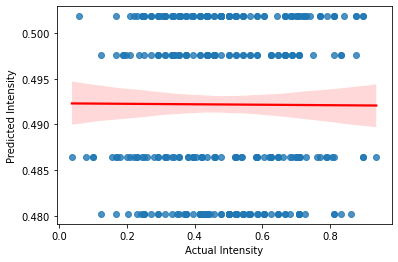

In [122]:
#Plotting distribution of actual intensity to the predicted intensity
sns.regplot(y_actual, y_predicted, line_kws={'color':'red'})
plt.xlabel("Actual Intensity")
plt.ylabel("Predicted Intensity")

Deep Learning Final Model

In [123]:
##ANN model with tf-idf vectorisation produce the smallest error, so it is chosen as the final model
y_actual_ = data_dev['score']
y_predicted_ = model1.predict(X_Dev_tfidf)
a=pd.DataFrame(y_actual_)
a['predicted']=y_predicted_

a
#pd.DataFrame(y_actual,s)
#pd.DataFrame(data={"Actual Intensity" : data_dev['score'], "Predicted Intensity" : model1.predict(X_Dev_tfidf)})

,score,predicted
0,0.479,0.486253
1,0.458,0.444924
2,0.562,0.625640
3,0.500,0.553734
4,0.708,0.539337
...,...,...
342,0.580,0.560246
343,0.170,0.406771
344,0.396,0.277267
345,0.156,0.240854


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Intensity')

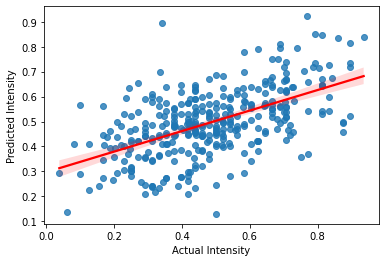

In [124]:
#Plotting distribution of actual intensity to the predicted intensity
sns.regplot(y_actual_, y_predicted_, line_kws={'color':'red'})
plt.xlabel("Actual Intensity")
plt.ylabel("Predicted Intensity")

Machine Learning Final Model

In [125]:
#SVR model with tf-idf vectorisation produce the smallest error, so it is chosen as the final model
y_actual__ = data_dev['score']
y_predicted__ = tfidf_svr.predict(X_Dev_tfidf)

pd.DataFrame(data={"Actual Intensity" : data_dev['score'], "Predicted Intensity" : tfidf_svr.predict(X_Dev_tfidf)})

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


,Actual Intensity,Predicted Intensity
0,0.479,0.470666
1,0.458,0.441662
2,0.562,0.595090
3,0.500,0.551515
4,0.708,0.577363
...,...,...
342,0.580,0.506936
343,0.170,0.442341
344,0.396,0.326551
345,0.156,0.322577


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Intensity')

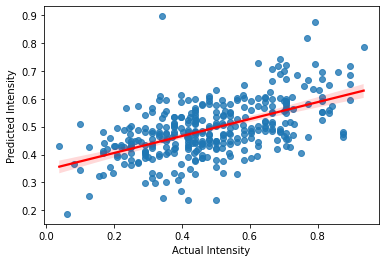

In [126]:
#Plotting distribution of actual intensity to the predicted intensity
sns.regplot(y_actual__, y_predicted__, line_kws={'color':'red'})
plt.xlabel("Actual Intensity")
plt.ylabel("Predicted Intensity")

# Testing
<a id='Testing'></a>

In [127]:
#Load testing data
#cols = ["id", "text", "label", "intensity"]


anger_test = pd.read_csv('/content/anger-ratings-0to1.test.target.txt',sep="\t",index_col=0)
fear_test = pd.read_csv('/content/fear-ratings-0to1.test.target.txt', sep="\t",index_col=0)
sad_test = pd.read_csv('/content/sadness-ratings-0to1.test.target.txt',sep="\t",index_col=0)
joy_test = pd.read_csv('/content/joy-ratings-0to1.test.target.txt',sep="\t",index_col=0)

anger_test.head()

,tweet,tweettype,score
id,,,
10941,At the point today where if someone says somet...,anger,NONE
10942,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger,NONE
10943,This game has pissed me off more than any othe...,anger,NONE
10944,@spamvicious I've just found out it's Candice ...,anger,NONE
10945,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger,NONE


In [128]:
frames = [anger_test, fear_test, sad_test, joy_test]
data_testing_ = pd.concat(frames)
data_testing_.reset_index(inplace=True)
data_testing_.tweettype.value_counts()

fear       995
anger      760
joy        714
sadness    673
Name: tweettype, dtype: int64

In [129]:
clean_data_test_list = tweet_cleaner(data_testing_)

Cleaning and parsing the tweets.....

Done!


In [130]:
labels = pd.get_dummies(data_testing_['tweettype'])

X_test_BoW = vectorizer.transform(data_testing_['tweet'])
X_test_BoW = pd.DataFrame.sparse.from_spmatrix(X_test_BoW).join(labels)

X_test_tfidf = vectorizer_tfidf.transform(data_testing_['tweet'])
X_test_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf).join(labels)

In [131]:
#predicting using the three best models from three approaches
#Statistical approach
pred_bow_glm=result_bow_glm.predict(X_test_BoW)
pd.DataFrame(pred_bow_glm)


,0
0,0.480225
1,0.480225
2,0.480225
3,0.480225
4,0.480225
...,...
3137,0.486450
3138,0.486450
3139,0.486450
3140,0.486450


In [132]:
#Deep Learning Approach
pred_tfidf_ann=model1.predict(X_test_BoW)
pd.DataFrame(pred_tfidf_ann)


,0
0,0.506825
1,0.383994
2,1.234562
3,0.712200
4,0.308958
...,...
3137,1.192916
3138,0.695222
3139,1.128678
3140,0.643981


In [133]:
#Machine Learning Approach
pred_tfidf_svr=tfidf_svr.predict(X_test_BoW)
pd.DataFrame(pred_tfidf_svr)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


,0
0,0.462426
1,0.428798
2,0.462423
3,0.462430
4,0.462925
...,...
3137,0.462422
3138,0.473614
3139,0.462415
3140,0.462504
